# Sensitivity Assessment

## Motivation

The study I did where I assessed the impact of higher $\Delta \eta_{hh}$ categories was based on the baseline analysis with the MDR+$\min D_{hh}$ paring algorithm which also included the MDpT cuts.

However, from my pairing and flows studies, I learned that these MDpT and MDR cuts both seem to be preferentially cutting out the higher $\Delta \eta_{hh}$ regions, which means I think I can get a "first guess" on this answer with some of the studies that Sean trained.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/']
from analysis import getXhh
from utils import mcToYr

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
physicsSample='SMNR'
mc='mc16d'
yr = mcToYr[mc]-2000

In [3]:
nomDir = '../data/SeanFiles/data_OCT27/'
revDir = '../data/SeanFiles/revdEta/'

In [4]:
scols = ['m_hh','m_h1','m_h2','mc_sf','abs_deta_hh','X_wt','ntag','kinematic_region']
bcols = ['m_hh','m_h1','m_h2','abs_deta_hh','X_wt','ntag',
         f'NN_d24_weight_bstrap_med_{yr}', f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

In [5]:
'''
Running with pag
'''

sdf = pd.concat([
        pd.read_hdf(f'../data/{physicsSample}_{mc}_PFlow-APR2020-5jets/df_SM_2b_{s}_3b.h5',columns=scols) 
            for s in ['even','odd']])
sdf = sdf[(sdf.ntag>=4) & (sdf.kinematic_region == 0) & (sdf.X_wt > 1.5)]

f_nom = uproot.open(f'{nomDir}/pairAGraph_SM_2b_all_{yr}_NN_100_bootstraps_IQR.root')
f_rev = uproot.open(f'{revDir}/pairAGraph_SM_2b_all_{yr}_NN_100_bootstraps_IQR.root')

bdf_nom = f_nom['sig'].pandas.df(bcols)
bdf_rev = f_rev['sig'].pandas.df(bcols)

bdf_nom =bdf_nom[(bdf_nom.X_wt > 1.5) & (bdf_nom.ntag==2)]
bdf_rev =bdf_rev[(bdf_rev.X_wt > 1.5) & (bdf_rev.ntag==2)]

In [6]:
for f, bdf in zip([f_nom,f_rev],[bdf_nom,bdf_rev]):
    bdf['w_2b']    = f[f'NN_norm_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_bstrap_med_{yr}']
    bdf['w_2b_VR'] = f[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

### Sensitivity estimate

Let's just get that classic s vs b plot for $\Delta \eta_{hh}$ above and below our cut boundary and a *first* significance estimate rn.

In [7]:
n,r = 40, (200,1200)

In [8]:
psymb = '$\mathrm{\mathbb{P}}$'

text = "$\mathbf{ATLAS}$ Internal\n"
text += f"20{yr} triggers: no buckets\n"
text += f"{psymb}"+"$_{SM}$ ($p_T$ sort), $X_{wt}$ > 1.5"

figDir = f'figures/{physicsSample}_{mc}-5jets/SM_2b'

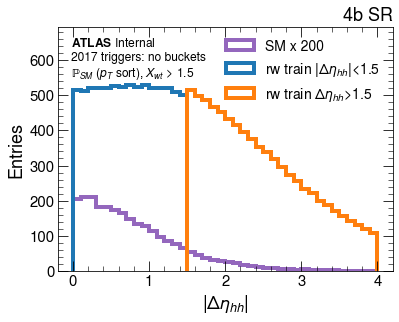

In [9]:
s = 200

plt.figure(figsize=(6,4.5))

plt.hist(sdf['abs_deta_hh'],40,(0,4), color='C4', histtype='step',lw=4,
         label=f'SM x {s}', weights=s*sdf['mc_sf'])

plt.hist(bdf_nom['abs_deta_hh'],15,(0,1.5), histtype='step',lw=4,
         label='rw train $|\Delta \eta_{hh}|$<1.5', weights=bdf_nom['w_2b'])
plt.hist(bdf_rev['abs_deta_hh'],25,(1.5,4), histtype='step',lw=4,
         label='rw train $\Delta \eta_{hh}$>1.5', weights=bdf_rev['w_2b'])
plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend()

_,ymax = plt.ylim()
plt.ylim(0,1.25*ymax)

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.title('4b SR',loc='right')

plt.savefig(f'{figDir}/abs_deta_hh_SR.pdf',bbox_inches='tight')

In [10]:
eta_edgs = np.arange(0,3,.5)
eta_edgs

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

In [11]:
idx = ['nom','rev'] + [f'{emin},{emax}' for emin,emax in zip(eta_edgs[:-1],eta_edgs[1:])]
cols = ['SR','shift']
zs = pd.DataFrame(0,idx,cols)

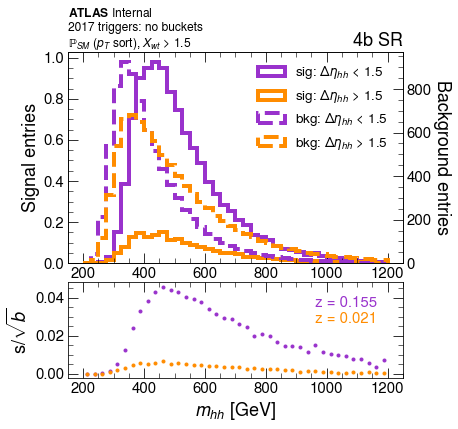

In [34]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[2,0],sharex=ax1)

ls = []
lc = ['darkorchid','darkorange']
for smask, bdf, l, c,i in zip([sdf.abs_deta_hh<1.5,sdf.abs_deta_hh>1.5],[bdf_nom,bdf_rev],
                              ['$\Delta \eta_{hh}$ < 1.5','$\Delta \eta_{hh}$ > 1.5'],lc,['nom','rev']):

    s,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
                     label=f'sig: {l}', weights=sdf.loc[smask,'mc_sf'])
    
    b,_,_ = ax2.hist(bdf['m_hh'],n,r, histtype='step',color=c,lw=4,ls='--',
                     label=f'bkg: {l}',weights=bdf['w_2b'])
    
    xx = 0.5 * (e[1:] + e[:-1])
    z = s/np.sqrt(b)
    
    ax3.plot(xx,z,lw=0,marker='.',color=c)
    zi = np.sqrt(np.sum(z**2))
    ls.append(f'z = {zi:.3f}')
    zs.loc[i,'SR'] = zi
    
    
ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Signal entries',fontsize=18)
ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
ax3.set_ylabel('s$ / \sqrt{b}$',fontsize=18)

ax1.legend(loc='upper left', bbox_to_anchor=(.53,1),fontsize=13.5)
ax2.legend(loc='upper left', bbox_to_anchor=(.53,.78),fontsize=13.5)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
ax1.set_title('4b SR',loc='right')

rainbow_text(950,.035, ls,lc, yoffset=1.1,ax=ax3,fontsize=15)
                    
plt.savefig(f'{figDir}/m_hh_SR_rev_deta.pdf',bbox_inches='tight')

In [13]:
np.sqrt(.155**2 + .02**2)/.155

1.0082902972959862

^ Ok, that plot is *garbage*, *overwhelmed* by background above the cut, this will only be useful if we have *categories* above deta_hh = 1.5

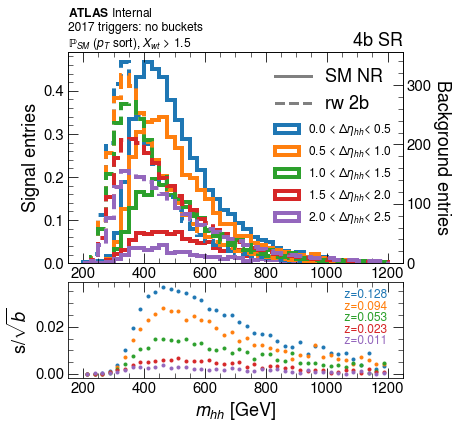

In [35]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[2,0],sharex=ax1)

ls = []
lc = []
for i,eta_min, eta_max in zip(range(10),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'
    
    smask = (sdf.abs_deta_hh > eta_min) & (sdf.abs_deta_hh < eta_max)
    s,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
                     label=f'{eta_min} < '+'$\Delta \eta_{hh}$'+f'< {eta_max}', 
                     weights=sdf.loc[smask,'mc_sf'])
    
    bdf = bdf_nom if eta_max <= 1.5 else bdf_rev
    bmask = (bdf.abs_deta_hh > eta_min) & (bdf.abs_deta_hh < eta_max)
    b,_,_ = ax2.hist(bdf.loc[bmask,'m_hh'],n,r, histtype='step',color=c,lw=4,ls='--',
                     weights=bdf.loc[bmask,'w_2b'])
    
    xx = 0.5 * (e[1:] + e[:-1])
    z = s/np.sqrt(b)
    
    ax3.plot(xx,z,lw=0,marker='.',color=c)
    zi = np.sqrt(np.sum(z**2))
    ls.append(f'z={zi:.3f}')
    lc.append(c)
    zs.loc[f'{eta_min},{eta_max}','SR'] = zi
    
    
for l,s in zip(['SM NR','rw 2b'],['-','--']):
    ax2.plot([],[],label=l,ls=s,color='grey')
    
ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Signal entries',fontsize=18)
ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
ax3.set_ylabel('s$ / \sqrt{b}$',fontsize=18)

ax1.legend(loc='upper right',bbox_to_anchor=(1,.72),fontsize=12)
ax2.legend(loc='upper left',bbox_to_anchor=(.57,1), fontsize=18)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
ax1.set_title('4b SR',loc='right')

rainbow_text(1200,.032, ls,lc, yoffset=.95,ax=ax3,fontsize=12,ha='right')
                    
plt.savefig(f'{figDir}/m_hh_SR_deta_cats.pdf',bbox_inches='tight')

**Goal:** Let's try to visualize the extra improvement we get from this $|\Delta \eta_{hh}|$ category.

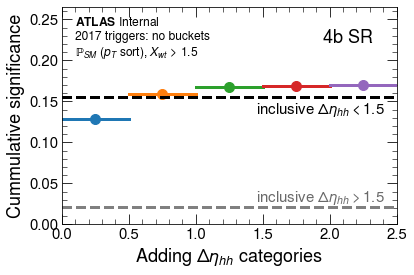

In [56]:
plt.plot(eta_edgs,zs.loc['nom','SR']*np.ones(6),'k--')
plt.plot(eta_edgs,zs.loc['rev','SR']*np.ones(6),color='grey',ls='--')

z_tot = 0

for i,eta_min, eta_max in zip(range(10),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'

    z_tot = np.sqrt(z_tot**2 + zs.loc[f'{eta_min},{eta_max}','SR']**2)
    
    eta_avg = 0.5 * (eta_min + eta_max)
    plt.scatter(eta_avg,z_tot,100,color=c)
    plt.plot([eta_min, eta_max],np.ones(2)*z_tot,c)

plt.xlabel('Adding $\Delta \eta_{hh}$ categories',fontsize=18)
plt.ylabel('Cummulative significance',fontsize=18)

_,ymax = plt.ylim()
plt.ylim(0,1.5*ymax)
plt.xlim(eta_edgs[[0,-1]])

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.text(.93,.9,'4b SR',ha='right',va='top',transform=ax.transAxes,fontsize=18)

xloc=1.45
eps=.004
plt.text(xloc, zs.loc['nom','SR']-eps,'inclusive $\Delta \eta_{hh} < 1.5$',va='top')
plt.text(xloc, zs.loc['rev','SR'],'inclusive $\Delta \eta_{hh} > 1.5$',va='bottom',color='dimgrey')

plt.savefig(f'{figDir}/significance_SR_deta_cats.pdf',bbox_inches='tight')

Rafael was *also* curious to see the individual significances.

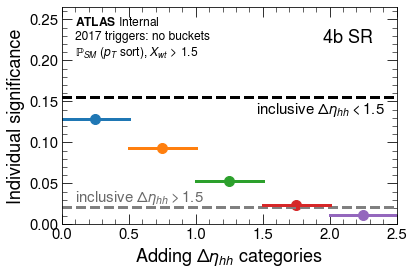

In [57]:
plt.plot(eta_edgs,zs.loc['nom','SR']*np.ones(6),'k--')
plt.plot(eta_edgs,zs.loc['rev','SR']*np.ones(6),color='grey',ls='--')

z_tot = 0

for i,eta_min, eta_max in zip(range(10),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'

    #z_tot = np.sqrt(z_tot**2 + zs.loc[f'{eta_min},{eta_max}','SR']**2)
    
    eta_avg = 0.5 * (eta_min + eta_max)
    zi = zs.loc[f'{eta_min},{eta_max}','SR']
    plt.scatter(eta_avg,zi,100,color=c)
    plt.plot([eta_min, eta_max],np.ones(2)*zi,c)

plt.xlabel('Adding $\Delta \eta_{hh}$ categories',fontsize=18)
plt.ylabel('Individual significance',fontsize=18)

plt.ylim(0,1.5*ymax)
plt.xlim(eta_edgs[[0,-1]])

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.text(.93,.9,'4b SR',ha='right',va='top',transform=ax.transAxes,fontsize=18)

plt.text(xloc, zs.loc['nom','SR']-eps,'inclusive $\Delta \eta_{hh} < 1.5$',va='top')
plt.text(.1, zs.loc['rev','SR'],'inclusive $\Delta \eta_{hh} > 1.5$',va='bottom',color='dimgrey')

plt.savefig(f'{figDir}/significance_ind_SR_deta_cats.pdf',bbox_inches='tight')

In [16]:
np.sqrt(.019**2 + .013**2)

0.023021728866442676

In [17]:
np.sqrt(.0336**2 + .02499**2 + .0141**2 + 0.0063**2)/.041

1.0885702491747875

In [18]:
np.sqrt(.041**2 + .0063**2)/.041

1.0117365990540998

In [19]:
np.sqrt(.031**2+.023**2)

0.03860051813123756

### Shifted SR

Might as well, since we know this helps the background anyways.

In [20]:
x0,y0 = 120, 110
x1,y1 = 124, 117

In [21]:
s2 = pd.concat([pd.read_hdf(f'../data/{physicsSample}_{mc}_PFlow-APR2020-5jets/df_SM_2b_{s}_3b.h5',
                            columns=scols) 
                 for s in ['even','odd']])

trees = ['sig','validation']
nom2 = pd.concat([f_nom[t].pandas.df(bcols) for t in trees], ignore_index=True)
rev2 = pd.concat([f_rev[t].pandas.df(bcols) for t in trees], ignore_index=True)


for df in [s2, nom2, rev2]:     
    df['Xhh_new'] = getXhh(*df[['m_h1','m_h2']].values.T,x1, y1)

# Cutty cuts!!
s2 = s2[(s2.ntag>=4) & (s2.Xhh_new < 1.6) & (s2.X_wt > 1.5)]

for f, bdf in zip([f_nom,f_rev],[nom2,rev2]):
    bdf['w_2b']    = f[f'NN_norm_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_bstrap_med_{yr}']
    bdf['w_2b_VR'] = f[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

nom2 =nom2[(nom2.X_wt > 1.5) & (nom2.ntag==2) & (nom2.Xhh_new < 1.6)]
rev2 =rev2[(rev2.X_wt > 1.5) & (rev2.ntag==2) & (nom2.Xhh_new < 1.6)]

Reminder of what the nominal plot is.

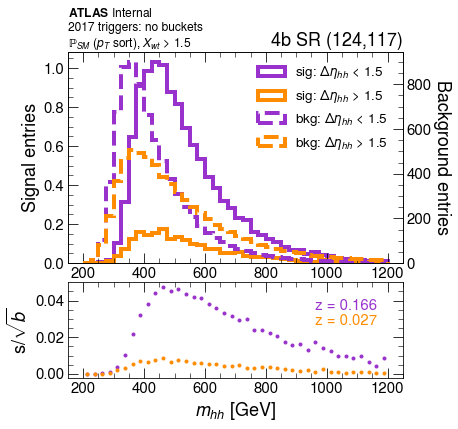

In [63]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[2,0],sharex=ax1)

ls = []
lc = ['darkorchid','darkorange']
for smask, bdf, l, c,i in zip([s2.abs_deta_hh<1.5,s2.abs_deta_hh>1.5],[nom2,rev2],
                              ['$\Delta \eta_{hh}$ < 1.5','$\Delta \eta_{hh}$ > 1.5'],lc,['nom','rev']):

    s,e,_ = ax1.hist(s2.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
                     label=f'sig: {l}', weights=s2.loc[smask,'mc_sf'])
    
    b,_,_ = ax2.hist(bdf['m_hh'],n,r, histtype='step',color=c,lw=4,ls='--',
                     label=f'bkg: {l}',weights=bdf['w_2b'])
    
    xx = 0.5 * (e[1:] + e[:-1])
    z = s/np.sqrt(b)
    
    ax3.plot(xx,z,lw=0,marker='.',color=c)
    zi = np.sqrt(np.sum(z**2))
    ls.append(f'z = {zi:.3f}')
    zs.loc[i,'shift'] = zi
    
    
ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Signal entries',fontsize=18)
ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
ax3.set_ylabel('s$ / \sqrt{b}$',fontsize=18)

ax1.legend(loc='upper left', bbox_to_anchor=(.53,1),fontsize=13.5)
ax2.legend(loc='upper left', bbox_to_anchor=(.53,.78),fontsize=13.5)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
ax1.set_title(f'4b SR ({x1},{y1})',loc='right')

rainbow_text(950,.035, ls,lc, yoffset=1.1,ax=ax3,fontsize=15)
                    
plt.savefig(f'{figDir}/m_hh_SR_{x1}_{y1}_rev_deta.pdf',bbox_inches='tight')

In [ ]:
np.sqrt(0.1664211887868471**2+ 0.026709413936278077**2)/ 0.166

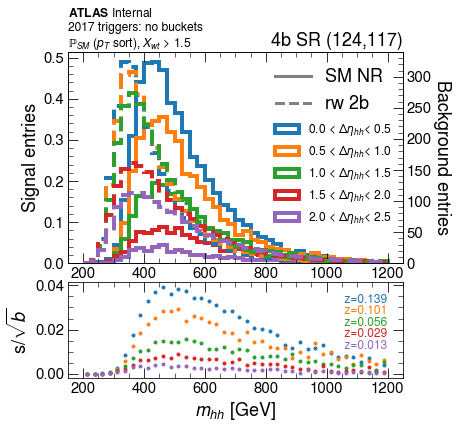

In [66]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[2,0],sharex=ax1)

ls = []
lc = []
for i,eta_min, eta_max in zip(range(10),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'
    
    smask = (s2.abs_deta_hh > eta_min) & (s2.abs_deta_hh < eta_max)
    s,e,_ = ax1.hist(s2.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
                     label=f'{eta_min} < '+'$\Delta \eta_{hh}$'+f'< {eta_max}', 
                     weights=s2.loc[smask,'mc_sf'])
    
    bdf = nom2 if eta_max <= 1.5 else rev2
    bmask = (bdf.abs_deta_hh > eta_min) & (bdf.abs_deta_hh < eta_max)
    b,_,_ = ax2.hist(bdf.loc[bmask,'m_hh'],n,r, histtype='step',color=c,lw=4,ls='--',
                     weights=bdf.loc[bmask,'w_2b'])
    
    xx = 0.5 * (e[1:] + e[:-1])
    z = s/np.sqrt(b)
    
    ax3.plot(xx,z,lw=0,marker='.',color=c)
    zi = np.sqrt(np.sum(z**2))
    ls.append(f'z={zi:.3f}')
    lc.append(c)
    zs.loc[f'{eta_min},{eta_max}','shift'] = zi
    
    
for l,s in zip(['SM NR','rw 2b'],['-','--']):
    ax2.plot([],[],label=l,ls=s,color='grey')
    
ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Signal entries',fontsize=18)
ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
ax3.set_ylabel('s$ / \sqrt{b}$',fontsize=18)

ax1.legend(loc='upper right',bbox_to_anchor=(1,.72),fontsize=12)
ax2.legend(loc='upper left',bbox_to_anchor=(.57,1), fontsize=18)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
ax1.set_title(f'4b SR ({x1},{y1})',loc='right')

rainbow_text(1200,.032, ls,lc, yoffset=.95,ax=ax3,fontsize=12,ha='right')
                    
plt.savefig(f'{figDir}/m_hh_SR_{x1}_{y1}_deta_cats.pdf',bbox_inches='tight')

In [ ]:
np.sqrt(0.025295227101775168**2+ 0.01679810137840571**2)

In [ ]:
np.sqrt(0.1664211887868471**2 + .03**2)/0.166

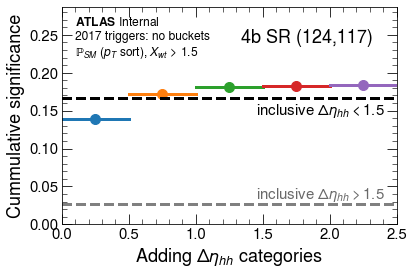

In [69]:
plt.plot(eta_edgs,zs.loc['nom','shift']*np.ones(6),'k--')
plt.plot(eta_edgs,zs.loc['rev','shift']*np.ones(6),color='grey',ls='--')

z_tot = 0

for i,eta_min, eta_max in zip(range(10),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'

    z_tot = np.sqrt(z_tot**2 + zs.loc[f'{eta_min},{eta_max}','shift']**2)
    
    eta_avg = 0.5 * (eta_min + eta_max)
    plt.scatter(eta_avg,z_tot,100,color=c)
    plt.plot([eta_min, eta_max],np.ones(2)*z_tot,c)

plt.xlabel('Adding $\Delta \eta_{hh}$ categories',fontsize=18)
plt.ylabel('Cummulative significance',fontsize=18)

_,ymax = plt.ylim()
plt.ylim(0,1.5*ymax)
plt.xlim(eta_edgs[[0,-1]])

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.text(.93,.9,f'4b SR ({x1},{y1})',ha='right',va='top',transform=ax.transAxes,fontsize=18)

xloc=1.45
eps=.004
plt.text(xloc, zs.loc['nom','shift']-eps,'inclusive $\Delta \eta_{hh} < 1.5$',va='top')
plt.text(xloc, zs.loc['rev','shift'],'inclusive $\Delta \eta_{hh} > 1.5$',va='bottom',color='dimgrey')

plt.savefig(f'{figDir}/significance_SR_{x1}_{y1}_deta_cats.pdf',bbox_inches='tight')

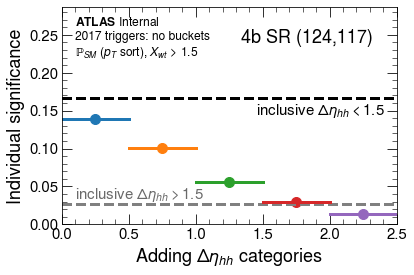

In [68]:
plt.plot(eta_edgs,zs.loc['nom','shift']*np.ones(6),'k--')
plt.plot(eta_edgs,zs.loc['rev','shift']*np.ones(6),color='grey',ls='--')

for i,eta_min, eta_max in zip(range(10),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'
    
    eta_avg = 0.5 * (eta_min + eta_max)
    zi = zs.loc[f'{eta_min},{eta_max}','shift']
    plt.scatter(eta_avg,zi,100,color=c)
    plt.plot([eta_min, eta_max],np.ones(2)*zi,c)

plt.xlabel('Adding $\Delta \eta_{hh}$ categories',fontsize=18)
plt.ylabel('Individual significance',fontsize=18)

plt.ylim(0,1.5*ymax)
plt.xlim(eta_edgs[[0,-1]])

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.text(.93,.9,f'4b SR ({x1},{y1})',ha='right',va='top',transform=ax.transAxes,fontsize=18)

plt.text(xloc, zs.loc['nom','shift']-eps,'inclusive $\Delta \eta_{hh} < 1.5$',va='top')
plt.text(.1, zs.loc['rev','shift'],'inclusive $\Delta \eta_{hh} > 1.5$',va='bottom',color='dimgrey')

plt.savefig(f'{figDir}/significance_ind_SR_{x1}_{y1}_deta_cats.pdf',bbox_inches='tight')